In [1]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import pickle
from tensorflow.keras.models import load_model

In [2]:
import pandas as pd
data=pd.read_csv('/content/sample_data/Apple.csv')

In [3]:
features = ['Open', 'High', 'Low', 'Close','Volume']

In [4]:
# Normalize the feature data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

In [5]:
# Create the time series dataset
time_step = 30
X, y = [], []
for i in range(len(scaled_data) - time_step):
    X.append(scaled_data[i:(i + time_step), :])
    y.append(scaled_data[i + time_step, 0])  # 'Open' is what we want to predict


In [6]:
import numpy as np
X, y = np.array(X), np.array(y)

X = X.reshape(X.shape[0], X.shape[1], len(features))

train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [7]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], len(features))))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [15]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/100
32/32 [==============================] - 1s 24ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 2/100
32/32 [==============================] - 1s 34ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 3/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 4/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 6/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 7/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 8/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 9/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 10/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0021 - val_loss: 0.0035

In [16]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


9/9 [==============================] - 0s 5ms/step


In [18]:
from sklearn.metrics import mean_squared_error

train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

# Calculating RMSE for Testing Data
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

print(f'Training Data RMSE: {train_rmse}')
print(f'Testing Data RMSE: {test_rmse}')

Training Data RMSE: 0.017684536654384395
Testing Data RMSE: 0.026482502819890494


In [19]:
import warnings

warnings.filterwarnings("ignore")

last_days = data[-time_step:]

last_days_scaled = scaler.transform(last_days[features])

X_last_days_scaled = last_days_scaled.reshape(1, time_step, len(features))

next_day_open_price_scaled = model.predict(X_last_days_scaled)

dummy_array = np.zeros((1, len(features)))
dummy_array[0, 0] = next_day_open_price_scaled

next_day_open_price = scaler.inverse_transform(dummy_array)[0, 0]

print(f"Predicted next day's opening price: {next_day_open_price}")

1/1 [==============================] - 0s 23ms/step
Predicted next day's opening price: 151.4160031990668


In [20]:
three_months_days = 90

predicted_prices = []

for i in range(len(data) - three_months_days - time_step, len(data) - time_step):
    X_input = data[i:i+time_step][features]
    X_input_scaled = scaler.transform(X_input)
    X_input_scaled = X_input_scaled.reshape(1, time_step, len(features))

    predicted_scaled = model.predict(X_input_scaled)

    dummy_array[0, 0] = predicted_scaled
    predicted_price = scaler.inverse_transform(dummy_array)[0, 0]
    predicted_prices.append(predicted_price)

actual_prices = data['Open'][-three_months_days:]



1/1 [==============================] - 0s 17ms/step


In [21]:
six_months_days = 180

predicted_prices = []

for i in range(len(data) - six_months_days - time_step, len(data) - time_step):
    X_input = data[i:i+time_step][features]
    X_input_scaled = scaler.transform(X_input)
    X_input_scaled = X_input_scaled.reshape(1, time_step, len(features))

    predicted_scaled = model.predict(X_input_scaled)

    dummy_array[0, 0] = predicted_scaled
    predicted_price = scaler.inverse_transform(dummy_array)[0, 0]
    predicted_prices.append(predicted_price)

actual_prices_6 = data['Open'][-six_months_days:]



1/1 [==============================] - 0s 17ms/step


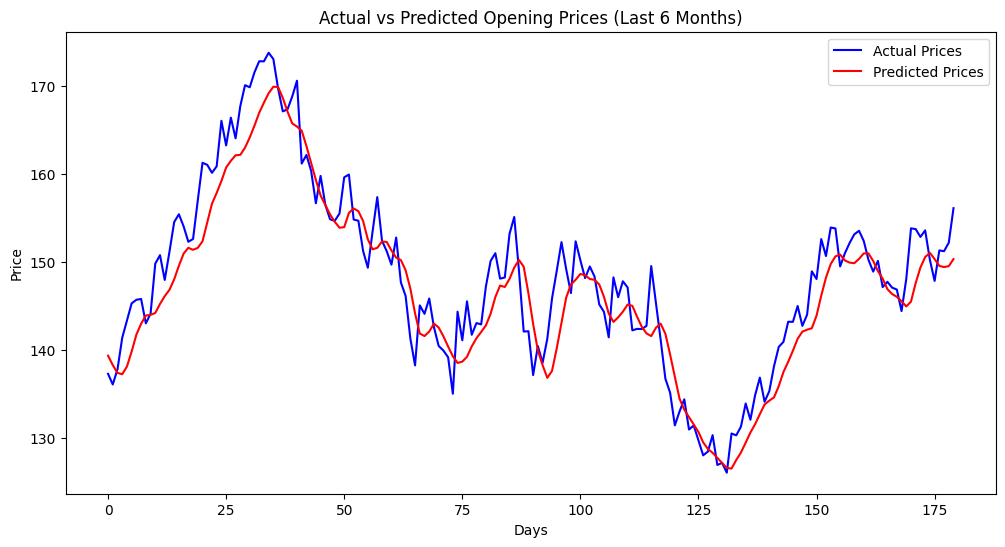

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(actual_prices_6.values, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.title('Actual vs Predicted Opening Prices (Last 6 Months)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()
